In [1]:
## importing necessary libraries:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy import stats as st
import scipy.stats as st
import os, re
import numpy as np
from matplotlib import ticker as mtick
import cmasher as cmr
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle
from scipy import stats as st
warnings.filterwarnings('ignore')
sns.set_style('white')

## setting up some parameters for making a clean and sound data visualization:
from matplotlib import rcParams
rcParams['figure.figsize']= (10.5,5)
rcParams['axes.linewidth']=0.3
rcParams['axes.labelsize']=15
rcParams['axes.titlesize']=18
rcParams['axes.titleweight']='semibold'
rcParams['axes.edgecolor']='grey'
rcParams['font.stretch']='semi-condensed'
rcParams['font.family']='sans-serif'
rcParams['legend.frameon']=False
rcParams['legend.fontsize']=10.5
rcParams['ytick.labelsize']=12.5
rcParams['xtick.labelsize']=12.5
rcParams['axes.spines.top']=False
rcParams['axes.spines.right']=False

In [5]:
## Print out No of rows and columns in a dataframe:
def data_shape(data):
    print('No of Rows: {a}\nNo of Columns:{b}'.format(a= data.shape[0], 
                                                      b= data.shape[1]))
    

## Funtion for encoding some categorial features:
def cat_encoder(series):
    zipped= zip(series.value_counts().sort_values().index, range(series.nunique()))
    dicts= dict(zipped)
    return series.map(dicts)

## Function for standard scaling of features:
def standard_scaler(series, ddof=None):
    if ddof:
        sd= np.std(series, ddof=ddof)
    else:
        sd= np.std(series)
    return (series-series.mean())/sd

## Function for Mix-Max Scaling (Normalization) of features:
def minmax_scaler(series):
    return(series-series.min())/(series.max()- series.min())    

## Function for relative frequency of a variable:
def relative_freq(series):
    return series/series.sum()

## Function for generating random colors:
def random_colors(size=1):
    import random
    return ['#'+''.join([i for i in shuffle('abcdef0123456789')][:6]) for i in range(size)]

In [6]:
## Function for computing p-values and z-score for One-sample hypothesis testing: 
def one_sample_ztest(x, hyp_mean,alpha, alternative= 'two-sided'):
    '''
    x: [array or list like]
    hyp_mean: Hypothesized Mean int|float
    alpha= significance float
    alternative: 
        'two-sided'
        'larger'
        'smaller'
    '''
    hyp_mean= hyp_mean
    mu= x.mean()
    std= np.std(x)
    se= std/(len(x)**0.5)
    z= (mu-hyp_mean)/se
    if alternative=='two-sided': p_val= (1-st.norm.cdf(abs(z)))**2
    else: p_val= (1-st.norm.cdf(abs(z)))
    return z, p_val

## Function to print out hypothesis results:
def results(p_val, alpha):
    if p_val<alpha:
        print('We reject the Null hypothesis(H0) with p-value:{:.5f}'.format(p_val))
    else:
        print('We failed to reject the H0 with p-value:{:.5f}'.format(p_val))
    
### Function for estimating confidence intervals:
def intervals(x, significance):
    mu= x.mean() # sample mean
    sigma= x.std() # sample std dev
    n= len(x) # size
    z= abs(st.norm.ppf((1-significance)/2)) ## get z-critical value
    se= sigma/(n**0.5) ## Compute standard error of mean
    l, r= mu-(z*se), mu+(z*se) ## estimate intervals
    return l,r

In [2]:
df= pd.read_csv('general_data.csv')
shuffle(df).head(3)

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
2490,36,No,Travel_Rarely,Research & Development,27,3,Technical Degree,1,2491,Female,...,7.0,Y,12,8,0,15.0,2,12,5,7
177,33,Yes,Travel_Rarely,Research & Development,10,3,Life Sciences,1,178,Female,...,7.0,Y,22,8,0,15.0,2,7,7,7
2295,40,Yes,Travel_Rarely,Research & Development,2,3,Medical,1,2296,Male,...,3.0,Y,15,8,1,15.0,3,5,1,0


### Data information

In [8]:
data_shape(df)

No of Rows: 4410
No of Columns:24


In [9]:
print('No of duplicate values: %a \n' %df.duplicated().any().sum())

print('No of Numerical Feature(s): {a}\nNo of Categorical Feature(s): {b}\n'.format(a=len(df.select_dtypes(exclude='O').columns), 
                                                                                  b=len(df.select_dtypes('O').columns) ))
print(df.info())

No of duplicate values: 0 

No of Numerical Feature(s): 16
No of Categorical Feature(s): 8

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null  

In [10]:
print('No of features holding missing values: {}'.format(df.isna().any().sum()))
print('Features with missing values:\n')
print(df.isna().sum()[df.isna().sum()>0].sort_values(ascending=False))

No of features holding missing values: 2
Features with missing values:

NumCompaniesWorked    19
TotalWorkingYears      9
dtype: int64


In [11]:
print('Percentage(%) of Missing values in each columns:\n')
percent_missing_values= df.isna().sum()[df.isna().sum()>0].apply(lambda x: x/len(df))
print(round((percent_missing_values*100).sort_values(ascending=False),2))

print('\nOverall missing values(%): {:.2f}%'.format(df.isna().sum().sum()/len(df)*100))

Percentage(%) of Missing values in each columns:

NumCompaniesWorked    0.43
TotalWorkingYears     0.20
dtype: float64

Overall missing values(%): 0.63%


### **Data Preparation and Cleaning:**

In [170]:
## Normalizing all the column names for simnplicity in analysis:
df.columns= df.columns.str.lower().str.strip()

In [171]:
## We'll not be imputing the NULLs as overall missing values in the data is less than 1%.
## Removing Field(s) with missing values:
df.dropna(inplace=True)

### **Exploratory data analysis:**

#### Descriptive Statistics

In [15]:
## Get a descriptive summary of the numerical feature(s) in the data:
print(round(df.describe().loc[['mean', 'std','min','75%','max'],:],3).T)

                              mean        std      min       75%       max
age                         36.933      9.137     18.0     43.00      60.0
distancefromhome             9.199      8.105      1.0     14.00      29.0
education                    2.912      1.025      1.0      4.00       5.0
employeecount                1.000      0.000      1.0      1.00       1.0
employeeid                2207.805   1271.689      1.0   3308.75    4409.0
joblevel                     2.064      1.106      1.0      3.00       5.0
monthlyincome            65061.702  47142.310  10090.0  83790.00  199990.0
numcompaniesworked           2.693      2.498      0.0      4.00       9.0
percentsalaryhike           15.211      3.663     11.0     18.00      25.0
standardhours                8.000      0.000      8.0      8.00       8.0
stockoptionlevel             0.795      0.852      0.0      1.00       3.0
totalworkingyears           11.290      7.786      0.0     15.00      40.0
trainingtimeslastyear    

* We can see **employeecount** column has same values across all the fields
* **monthlyincome** has a positively skewed distribution
* **age** has gaussian(normal) like distribution

In [16]:
## What is the overall attrition rate in the data:
print('Overall Attrition rate: {:.2%}'.format((df.attrition=='Yes').sum()/len(df)))

Overall Attrition rate: 16.09%


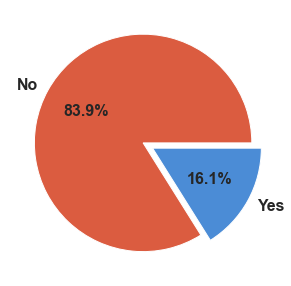

In [17]:
plt.pie(df.attrition.value_counts(), explode= [0,0.1], autopct='%.1f%%',
        colors= ['#db5c40','#4b8cd6'], labels= ['No','Yes'], textprops= {'weight':'bold', 'size': 16})
plt.show()

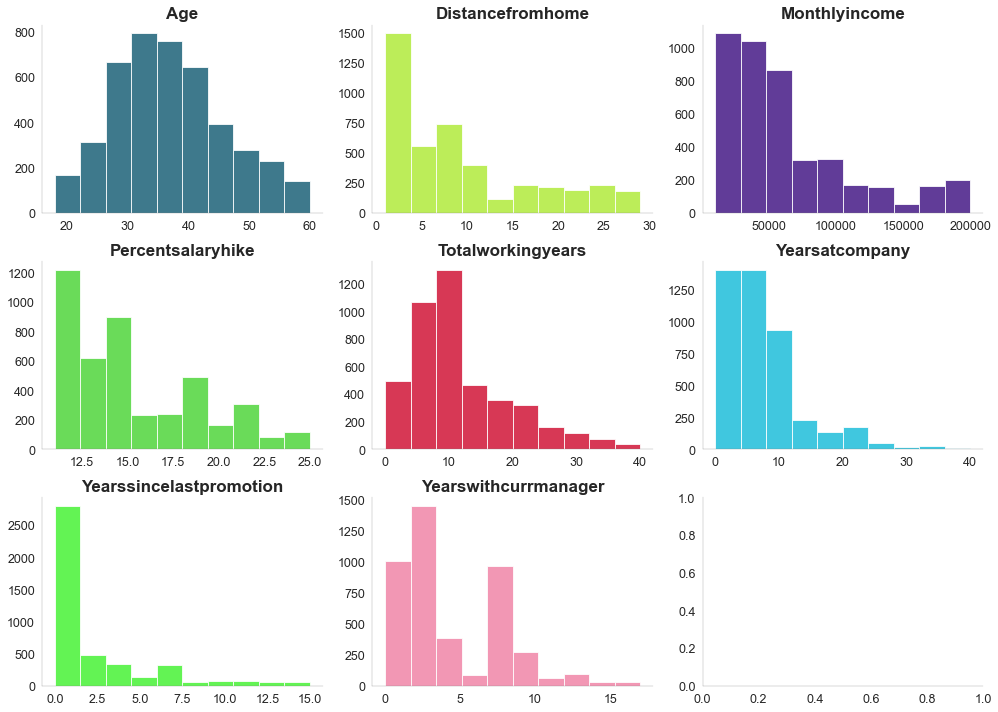

In [18]:
### Distribution across all the continuous variables:
cols= df.columns[df.nunique()>10].drop('employeeid')
fig, ax= plt.subplots(round(len(cols)/3), 3, figsize= (14,10))
ax= ax.ravel()
for i in range(len(cols)):
    ax[i].hist(df[cols[i]],color=random_colors(), alpha=0.8)
    ax[i].set_title(cols[i].capitalize(), size=17)
plt.tight_layout()

* `Most of the features follow a positively skewed distribution`
* `Age follows a gaussian-like distribution`

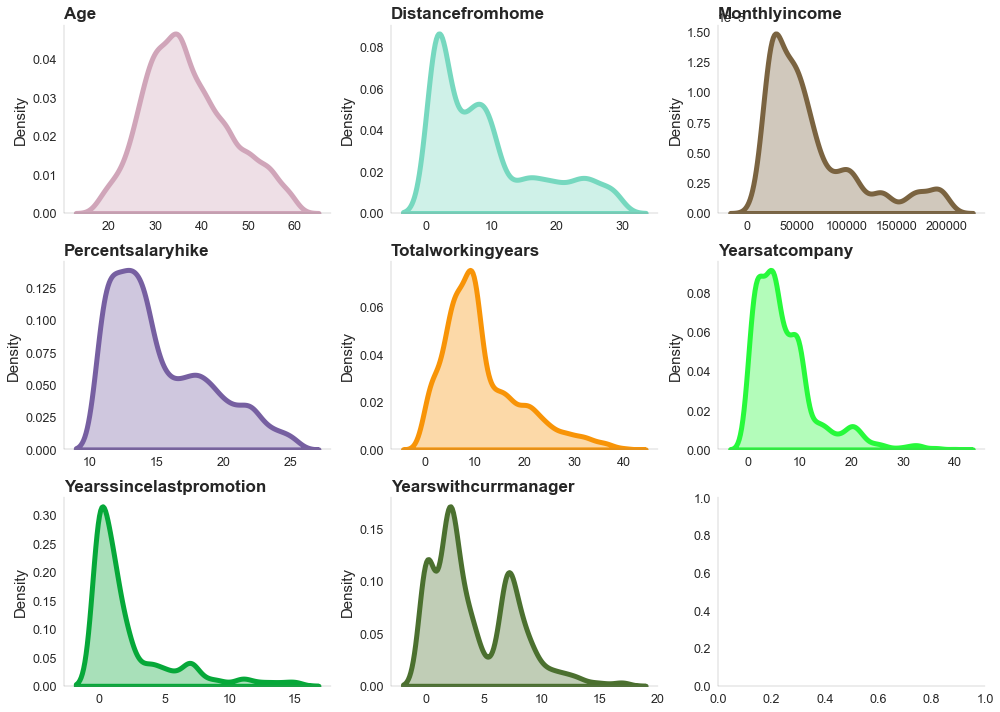

In [19]:
### Distribution across all the continuous variables:
cols= df.columns[df.nunique()>10].drop('employeeid')
fig, ax= plt.subplots(round(len(cols)/3), 3, figsize= (14,10))
ax= ax.ravel()
for i in range(len(cols)):
    sns.kdeplot(df[cols[i]],shade=True ,color=random_colors(), lw=5, alpha=0.35, ax=ax[i])
    ax[i].set_title(cols[i].capitalize(), size=17, loc='left')
    ax[i].set_xlabel('')
plt.tight_layout()

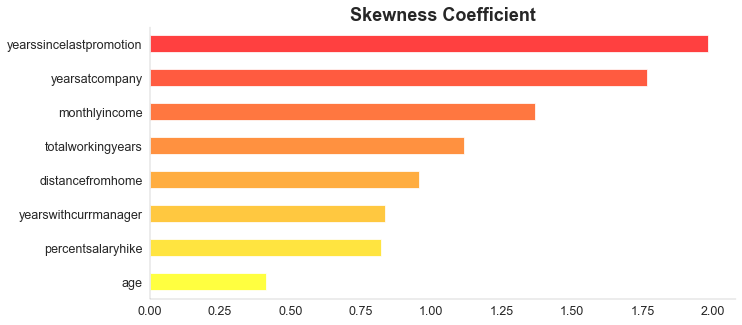

In [20]:
df[cols].skew().sort_values().plot(kind='barh', alpha=0.75,color= cmr.take_cmap_colors('autumn_r', len(cols), return_fmt='hex'))
plt.title('Skewness Coefficient')
plt.show()

##### `Columns such as 'yearssincelastpromotion', 'yearsatcompany', 'monthlyincome' and 'totalworkingyears' are highly skewed.`

In [21]:
data= df.age
spl= data.sample(frac=.10, replace=True)

In [22]:
print('Square root transformation: ' ,'{:.3f}'.format((spl**0.5).skew()))
print('Cube root transformation: ','{:.3f}'.format((spl**0.33).skew()))
print('Log transformation: ','{:.3f}'.format(np.log(spl).skew()))
print('Inverse transformation: ','{:.3f}'.format((1/spl).skew()))

Square root transformation:  0.334
Cube root transformation:  0.229
Log transformation:  0.017
Inverse transformation:  0.701


##### `As we can see, square root transformation has the lowest skewness (0.004) , therefore we will use square root transformation for  'Age' to convert it to Gaussian distribution`

#### *Lets get some statistical inference from 'Age':*

#### **Is average 'Age' of employees more than 36?**
- **`Null Hypothesis H0:`** $mu = \sqrt36$
- **`Alt. Hypothesis H1:`** $mu > \sqrt36$

In [23]:
spl= spl**0.5

In [24]:
hyp_mean= np.sqrt(36)
results(one_sample_ztest(x=spl, hyp_mean=hyp_mean, alternative='larger', alpha=0.05)[1], alpha=0.05)

We failed to reject the H0 with p-value:0.43589


#### Estimate population mean for age with 95% confidence:

In [25]:
significance= .96
cis= intervals(spl, significance)
print('With {:.0%} confidence, Population mean is estimated to lie between {:.3f} and {:.3f}'.format(significance, cis[0], cis[1]))

With 96% confidence, Population mean is estimated to lie between 5.923 and 6.066


In [26]:
df.age.mean()**0.5

6.077282596756531

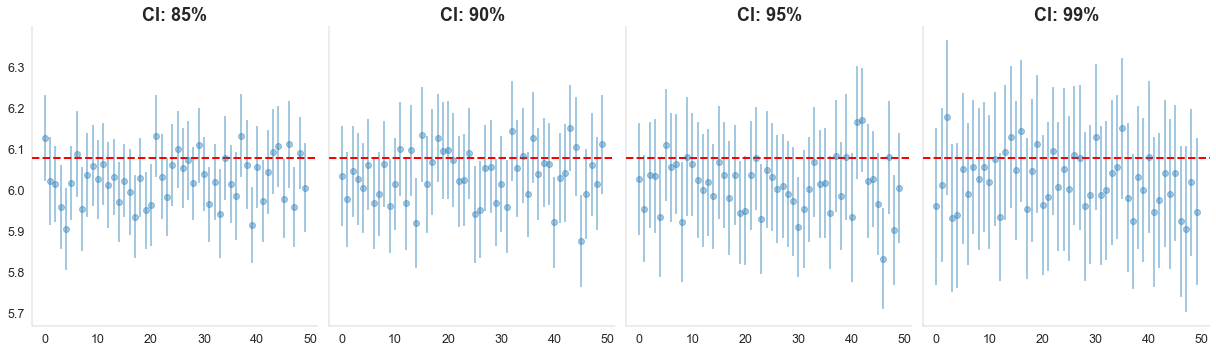

In [27]:
fig, ax= plt.subplots(1,4,sharey=True ,figsize= (17,5))
ax= ax.ravel()
for ind, i in enumerate([.85,.90,.95,.99]):
    interval, means=[],[]
    for j in range(50):
        sample= df.age.sample(120, replace=True)
        sample= sample**0.5
        interval.append(intervals(sample, significance=i))
        means.append(sample.mean())
    li= [i[0] for i in interval]
    ri= [i[1] for i in interval]
    x= range(len(li))
    ax[ind].errorbar(x, means, yerr= [(i-j)/2 for i, j in zip(li,ri)], lw=2, fmt='o', alpha=0.4)
    ax[ind].axhline(y= df.age.mean()**0.5, lw=2, ls='--', color='red')
    ax[ind].set_title('CI: {:.0%}'.format(i))
plt.tight_layout()

#### *Notice that in the plots above, after sampling, we see that when significance is 95%, confidence Intervals finds the true population mean 95% of the time, same with 85% significance and so on and so forth. Also, with increase in significance level, difference between the upper bound and lower bound also increases*

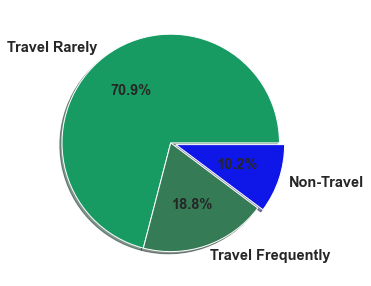

In [28]:
plt.pie(df.businesstravel.value_counts(), labels= df.businesstravel.value_counts().index.str.replace('_',' '), 
           autopct='%0.1f%%', textprops= {'weight': 'bold', 'size': 14.5}, colors= random_colors(3),
           explode= [0,0,0.05], shadow=True)
plt.show()

### Predictive modelling

In [64]:
class CustomEncoder:
    def __init__(self, columns=None):
        self.columns= columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        from sklearn.preprocessing import LabelEncoder
        out= X.copy()
        if self.columns is not None:
            out[self.columns]= out[self.columns].apply(LabelEncoder().fit_transform)
        else:
            out= out.apply(LabelEncoder().fit_transform)
        return out
    
    def fit_transform(self, X,y=None):
        return self.fit(X).transform(X)

In [172]:
df.drop(['standardhours','over18','employeecount'], axis=1, inplace=True)
df_dummy= CustomEncoder(columns= df.select_dtypes('O').columns).fit_transform(df)
df_dummy.head()

,age,attrition,businesstravel,department,distancefromhome,education,educationfield,employeeid,gender,joblevel,...,maritalstatus,monthlyincome,numcompaniesworked,percentsalaryhike,stockoptionlevel,totalworkingyears,trainingtimeslastyear,yearsatcompany,yearssincelastpromotion,yearswithcurrmanager
0,51,0,2,2,6,2,1,1,0,1,...,1,131160,1.0,11,0,1.0,6,1,0,0
1,31,1,1,1,10,1,1,2,0,1,...,2,41890,0.0,23,1,6.0,3,5,1,4
2,32,0,1,1,17,4,4,3,1,4,...,1,193280,1.0,15,3,5.0,2,5,0,3
3,38,0,0,1,2,5,1,4,1,3,...,1,83210,3.0,11,3,13.0,5,8,7,5
4,32,0,2,1,10,1,3,5,1,1,...,2,23420,4.0,12,2,9.0,2,6,0,4


<AxesSubplot:>

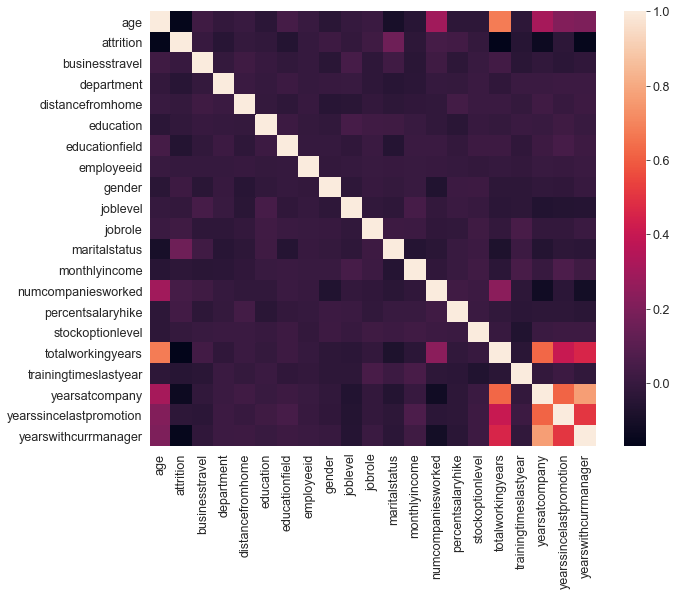

In [160]:
plt.figure(figsize= (10,8))
sns.heatmap(df_dummy.corr())

<AxesSubplot:xlabel='age', ylabel='attrition'>

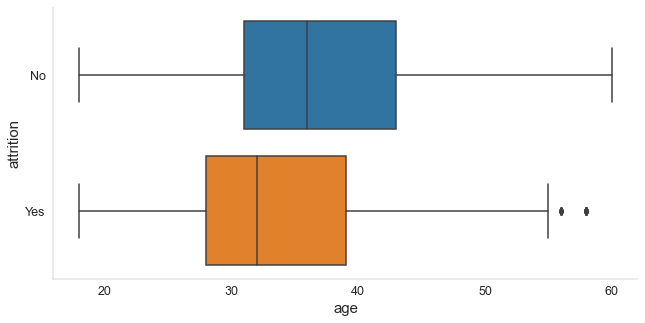

In [134]:
sns.boxplot(y=df.attrition, x=df.age, orient='horizontal')

In [142]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics as mt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, RobustScaler
from sklearn.pipeline import Pipeline

In [173]:
df_dummy.drop('employeeid', axis=1, inplace=True)
X= df_dummy.drop('attrition', axis=1)[list(sfs.k_feature_names_)]
y= df_dummy.attrition

In [174]:
X_train,X_test, y_train, y_test= train_test_split(X,y, random_state=42, test_size=.20)
X_train.shape, X_test.shape

((3505, 9), (877, 9))

In [175]:
steps= [('sc', StandardScaler()),
        ('lm', RandomForestClassifier())]
pipe= Pipeline(steps= steps)

In [176]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('sc', StandardScaler()), ('lm', RandomForestClassifier())])

In [177]:
print('Evaluation metrics:')
print(f'Train Accuracy:{pipe.score(X_train, y_train):.2%}')
print(f'Test Accuracy:{pipe.score(X_test, y_test):.2%}')

Evaluation metrics:
Train Accuracy:100.00%
Test Accuracy:100.00%


In [178]:
pred_train= pipe.predict(X_train)
pred_test= pipe.predict(X_test)
pred_prob= pipe.predict_proba(X_test)[:,1]

print('Training Classification report')
print(mt.classification_report(y_train, pred_train))
print('-'*50)
print('Testing Classification report')
print(mt.classification_report(y_test, pred_test))

Training Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2922
           1       1.00      1.00      1.00       583

    accuracy                           1.00      3505
   macro avg       1.00      1.00      1.00      3505
weighted avg       1.00      1.00      1.00      3505

--------------------------------------------------
Testing Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       755
           1       1.00      1.00      1.00       122

    accuracy                           1.00       877
   macro avg       1.00      1.00      1.00       877
weighted avg       1.00      1.00      1.00       877



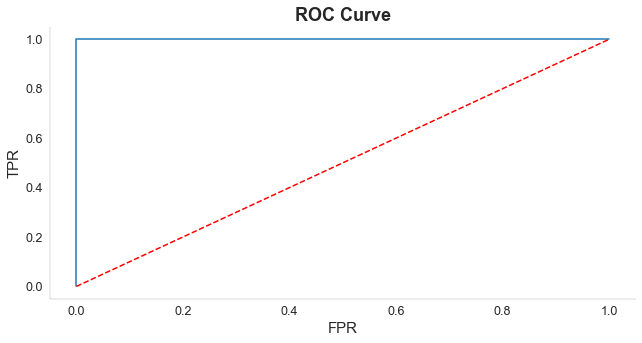

In [167]:
fpr, tpr, thresholds= mt.roc_curve(y_test, pred_prob)
roc_auc= mt.roc_auc_score(y_test, pred_prob)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], ls='--', color='red')
plt.title('ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector
sfs= SequentialFeatureSelector(pipe, k_features= (2,10), scoring='accuracy')
sfs.fit(X_train, y_train)

SequentialFeatureSelector(estimator=Pipeline(steps=[('sc', StandardScaler()),
                                                    ('lm',
                                                     RandomForestClassifier())]),
                          k_features=(2, 10), scoring='accuracy')

In [182]:
import pickle
with open('model.pkl','wb') as ref:
    pickle.dump(pipe, ref)

In [185]:
with open('df.pkl','wb') as ref:
    pickle.dump(df[list(sfs.k_feature_names_)], ref)